In [150]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
import pandas as pd
import numpy as np
import scienceplots
plt.style.use(['science','ieee'])
log_file_path = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/tb_logs/PPO_20240420_140821_1/events.out.tfevents.1713636502.holodeck.2392170.10"

def read_tensorboard_data(log_file_path, tag_name='eval/mean_reward'):
    """
    Read specified tag data from a TensorBoard log file.

    Parameters:
    log_file_path (str): Path to the TensorBoard log file.
    tag_name (str): Tag of the data to read.

    Returns:
    list of tuples: Each tuple contains (step, value) for the entries under the specified tag.
    """
    data = []
    try:
        for e in summary_iterator(log_file_path):
            for v in e.summary.value:
                if v.tag == tag_name:
                    data.append((e.step, v.simple_value))
    except Exception as ex:
        print(f"Error reading {log_file_path}: {str(ex)}")
    return data

# Retrieve the eval/mean_reward data
eval_data = read_tensorboard_data(log_file_path, 'eval/mean_reward')
#eval_data = read_tensorboard_data(log_file_path, 'rollout/ep_rew_mean')

# Convert the data to a DataFrame
df = pd.DataFrame(eval_data, columns=['Step', 'Mean Reward'])
df['Transformed Reward'] = (1/np.exp(1 / df['Mean Reward']))
df['Normalized Transformed Reward'] = df['Transformed Reward'] / df['Transformed Reward'].max()
df['Episodes'] = df['Step'] /8
# Display the DataFrame
print(df)


          Step  Mean Reward  Transformed Reward  \
0         4992     0.051529        3.730734e-09   
1         9984     0.024071        9.074985e-19   
2        14976     0.024071        9.074985e-19   
3        19968     0.028513        5.866571e-16   
4        24960     0.014457        9.119815e-31   
...        ...          ...                 ...   
2059  10283520     0.177114        3.531295e-03   
2060  10288512     0.177114        3.531295e-03   
2061  10293504     0.160806        1.991871e-03   
2062  10298496     0.157726        1.764089e-03   
2063  10303488     0.157726        1.764089e-03   

      Normalized Transformed Reward   Episodes  
0                      4.866242e-07      624.0  
1                      1.183710e-16     1248.0  
2                      1.183710e-16     1872.0  
3                      7.652155e-14     2496.0  
4                      1.189558e-28     3120.0  
...                             ...        ...  
2059                   4.606101e-01  1285440

In [151]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your DataFrame that has already been loaded with 'Step' and 'Mean Reward'
# Example: Load your DataFrame here if not already loaded
# df = pd.read_csv('path_to_your_data.csv')

# Adding a constant to the model (statsmodels does not add it by default)
X = sm.add_constant(df['Episodes'])  # Predictor
y = df['Normalized Transformed Reward']            # Response

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


                                  OLS Regression Results                                 
Dep. Variable:     Normalized Transformed Reward   R-squared:                       0.203
Model:                                       OLS   Adj. R-squared:                  0.203
Method:                            Least Squares   F-statistic:                     525.6
Date:                           Sun, 21 Apr 2024   Prob (F-statistic):          8.48e-104
Time:                                   17:43:54   Log-Likelihood:                 760.54
No. Observations:                           2064   AIC:                            -1517.
Df Residuals:                               2062   BIC:                            -1506.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

/tmp/ipykernel_2510442/4132559237.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x/1_000_000:.1f}M' for x in current_ticks])


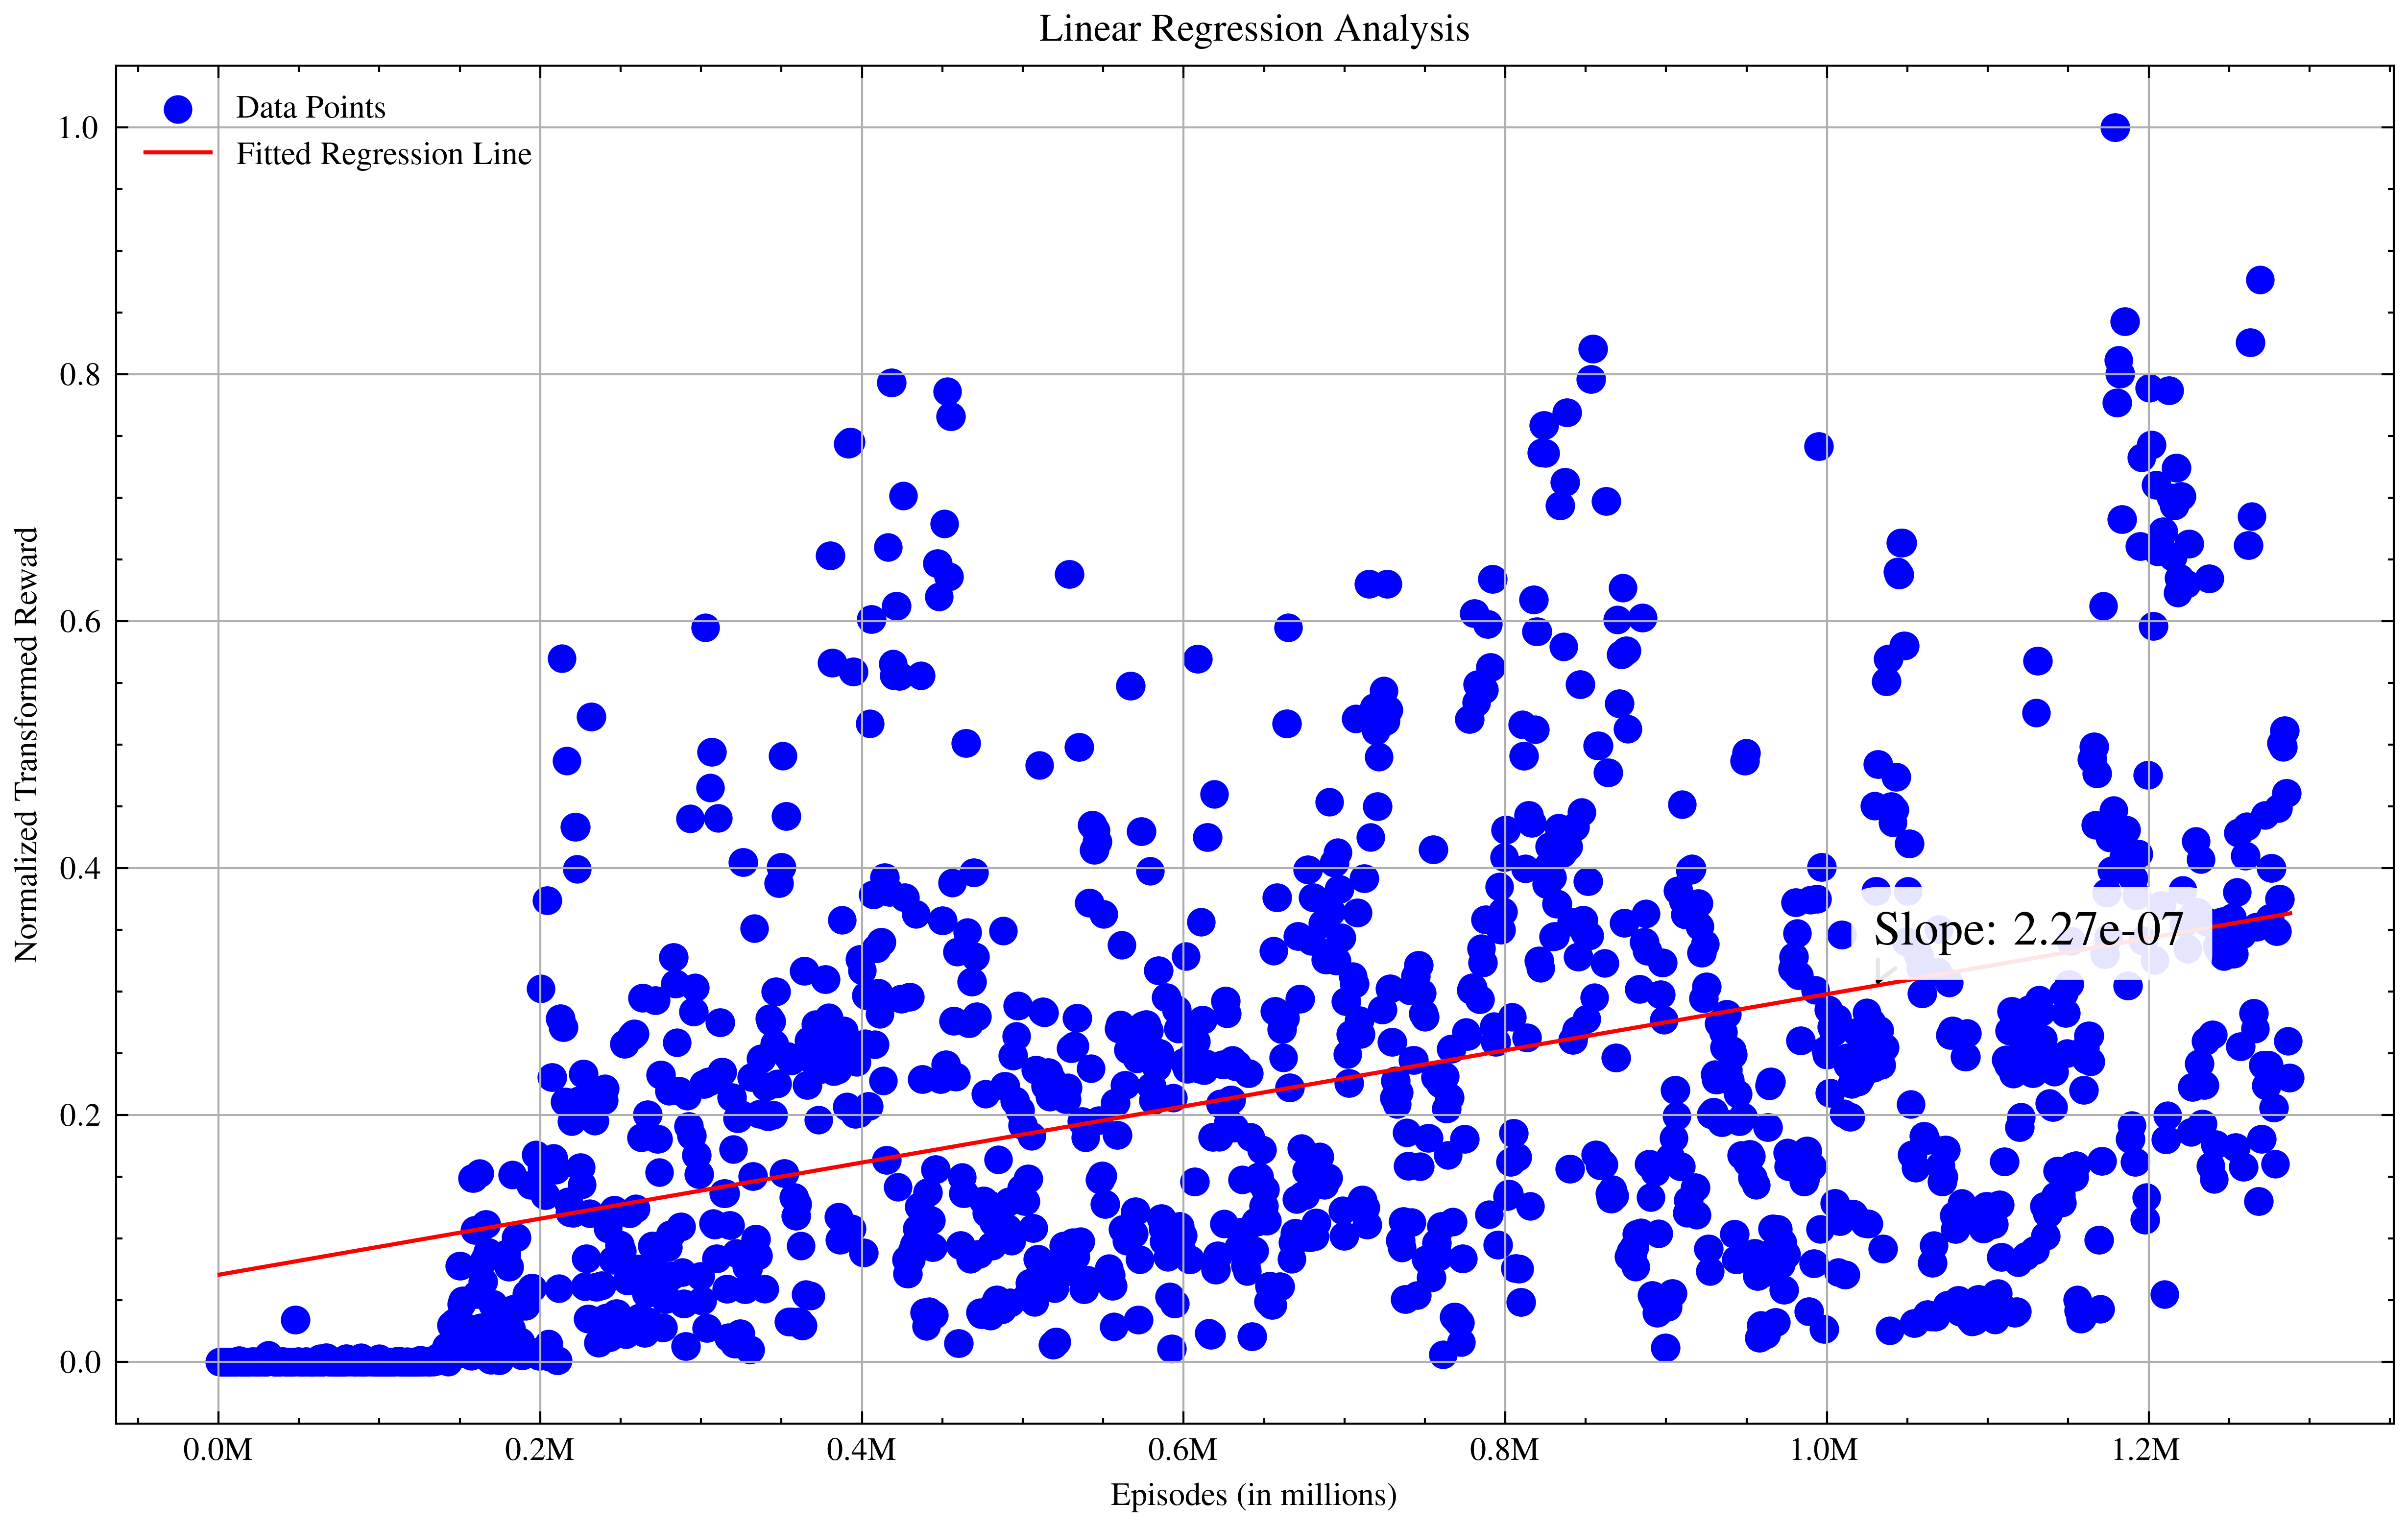

In [152]:
import matplotlib.pyplot as plt

# Assuming df['Episodes'] and df['Predicted'] are already defined as per your description
df['Predicted'] = model.predict(X)  # Predicted values for the regression line

plt.figure(figsize=(10, 6))
plt.scatter(df['Episodes'], df['Normalized Transformed Reward'], color='blue', label='Data Points')
plt.plot(df['Episodes'], df['Predicted'], color='red', label='Fitted Regression Line')

# Calculate a position for the annotation
x_pos = df['Episodes'].max() * 0.8  # 80% along the x-axis range
y_pos = df['Predicted'].iloc[(df['Episodes'].searchsorted(x_pos))]  # corresponding y from the model

# Annotation for the slope in scientific notation
slope = model.params['Episodes']
plt.annotate(f'Slope: {slope:.2e}', xy=(x_pos, y_pos), textcoords="offset points", xytext=(0,10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

plt.title('Linear Regression Analysis')
plt.xlabel('Episodes (in millions)')
plt.ylabel('Normalized Transformed Reward')
plt.legend()
plt.grid()

# Get current x-axis ticks and convert them to millions
current_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x/1_000_000:.1f}M' for x in current_ticks])

plt.show()


In [153]:
# Create a new DataFrame with the specific X value at which you want to predict the y-value
predict_df = pd.DataFrame({'const': [1], 'Episodes': [100]})  # Note: 'const' column must be included if the model includes it

# Predicting the y-value at X = 100
predicted_value = model.predict(predict_df)
print(f'The predicted y-value at X = 100 is {predicted_value[0]}')

The predicted y-value at X = 100 is 0.07046716740511552
